## CIFAR-100 training script
Note: This script merely outlines the procedures for training pytorch model. It does not replicate any study and does not attemp to achieve state-of-the-art in CIFAR-100 classification.

In [1]:
from copy import deepcopy
from datetime import datetime
from os import makedirs
from os.path import join, isfile, isdir

import psutil
import torch
import torch.nn as nn
import torch.optim as optim

from efficientnet import EfficientNet
from sklearn.metrics import accuracy_score
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def train_model(model, dataloader, device, criterion, optimizer):
    model.train()
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        if out.size(1) == 1:
            # regression, squeeze output of shape [N,1] to [N]
            out = torch.squeeze(out, 1)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()


def eval_model(model, dataloader, device, criterion=None):
    loss_value = []
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            if out.size(1) == 1:
                # regression, squeeze output of shape [N,1] to [N]
                out = torch.squeeze(out, 1)

            if criterion is not None:
                loss = criterion(out, yb)
                loss_value.append(loss.item())

            y_pred.append(out.detach().cpu())
            y_true.append(yb.detach().cpu())

    if criterion is not None:
        loss_value = sum(loss_value) / len(loss_value)
        return torch.cat(y_pred), torch.cat(y_true), loss_value
    else:
        return torch.cat(y_pred), torch.cat(y_true)


def run_experiment(dl_train,
                   dl_train_val,
                   dl_validation,
                   model,
                   optimizer,
                   criterion,
                   device,
                   max_epoch,
                   metric_fn,
                   init_epoch=0,
                   scheduler=None,
                   load_path=None,
                   save_path=None,
                   early_stopping=None,
                   ):
    results = {
        "train_loss": [],
        "valid_loss": [],
        "train_met": [],
        "valid_met": [],
        "state_dict": None,
    }

    best_validation_metric = .0
    model_best_state_dict = None
    no_score_improvement = 0
    experiment_start = datetime.now()

    if load_path is not None:
        # load full experiment state to continue experiment
        load_path = join(load_path, "full_state.pth")
        if not isfile(load_path):
            raise ValueError("Checkpoint file {} does not exist".format(load_path))

        checkpoint = torch.load(load_path)

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        model_best_state_dict = checkpoint['model_best_state_dict']
        model.load_state_dict(checkpoint['model_curr_state_dict'])

        init_epoch = checkpoint['epoch']
        best_validation_metric = checkpoint['best_validation_metric']

        if scheduler is not None:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        print("Successfully loaded checkpoint.")

    s = "Epoch/Max | Loss: Train / Validation | Metric: Train / Validation | Epoch time"
    print(s)

    if save_path is not None and not isdir(save_path):
        makedirs(save_path)
    for epoch in range(init_epoch, max_epoch):
        now = datetime.now()
        train_model(model=model,
                    dataloader=dl_train,
                    device=device,
                    criterion=criterion,
                    optimizer=optimizer, )

        # evaluate subset of train set (in eval mode)
        train_val_results = eval_model(model=model,
                                       dataloader=dl_train_val,
                                       device=device,
                                       criterion=criterion, )
        train_y_pred, train_y_true, train_loss = train_val_results
        train_metric = metric_fn(train_y_pred, train_y_true)
        results["train_loss"].append(train_loss)
        results["train_met"].append(train_metric)

        # evaluate validation subset
        valid_results = eval_model(model=model,
                                   dataloader=dl_validation,
                                   device=device,
                                   criterion=criterion, )
        valid_y_pred, valid_y_true, valid_loss = valid_results
        validation_metric = metric_fn(valid_y_pred, valid_y_true)
        results["valid_loss"].append(valid_loss)
        results["valid_met"].append(validation_metric)

        # check if validation score is improved
        if validation_metric > best_validation_metric:
            model_best_state_dict = deepcopy(model.state_dict())
            best_validation_metric = validation_metric
            # reset early stopping counter
            no_score_improvement = 0
            # save best model weights
            if save_path is not None:
                torch.save(model_best_state_dict, join(save_path, "best_weights.pth"))
        else:
            no_score_improvement += 1
            if early_stopping is not None and no_score_improvement >= early_stopping:
                print("Early stopping at epoch %d" % epoch)
                break

        if scheduler is not None:
            scheduler.step(validation_metric)

        if save_path is not None:
            # (optional) save model state dict at end of each epoch
            # torch.save(model.state_dict(), join(save_path, "model_state_{}.pth".format(epoch)))

            # save full experiment state at the end of each epoch
            checkpoint = {
                'epoch': epoch + 1,
                'model_curr_state_dict': model.state_dict(),
                'model_best_state_dict': model_best_state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': None if scheduler is None else scheduler.state_dict(),
                'no_score_improvement': no_score_improvement,
                'best_validation_metric': best_validation_metric,
            }
            torch.save(checkpoint, join(save_path, "full_state.pth"))

        s = "{:>5}/{} | Loss: {:.4f} / {:.4f}".format(epoch, max_epoch, train_loss, valid_loss)
        s += " | Metric: {:.4f} / {:.4f}".format(train_metric, validation_metric)
        s += " | +{}".format(datetime.now() - now)
        print(s)

    print("Experiment time: {}".format(datetime.now() - experiment_start))
    return results

In [3]:
model_index = 0 # i.e. EfficientNet-B{model_index}
batch_size = 128
max_epoch = 100
n_classes = 100
pretrained=False
num_workers = psutil.cpu_count()
img_size = 32

def metric_fn(y_pred, y_true):
    _, y_pred = torch.max(y_pred, 1)
    return accuracy_score(y_pred, y_true)

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(img_size, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507075, 0.48655024, 0.44091907],
                         std=[0.26733398, 0.25643876, 0.2761503]),
])

transform_validation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5070754,  0.48655024, 0.44091907],
                         std=[0.26733398, 0.25643876, 0.2761503]),
])

dataset_train = datasets.CIFAR100(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transform_train,
                                  )
dataset_train_val = datasets.CIFAR100(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform_validation,
                                      )
dataset_validation = datasets.CIFAR100(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_validation,
                                       )

dataloader_train = DataLoader(dataset_train,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              )
dataloader_train_val = DataLoader(dataset_train_val,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers,
                                  )
dataloader_validation = DataLoader(dataset_validation,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   num_workers=num_workers,
                                   )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet(b=model_index,
                     in_spatial_shape=img_size,
                     n_classes=n_classes,
                     pretrained=pretrained,
                     )
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,60,90], gamma=0.1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
exp_results = run_experiment(dl_train=dataloader_train,
                             dl_train_val=dataloader_train_val,
                             dl_validation=dataloader_validation,
                             model=model,
                             optimizer=optimizer,
                             criterion=criterion,
                             device=device,
                             max_epoch=max_epoch,
                             metric_fn=metric_fn,
                             scheduler=scheduler,
                             load_path=None,
                             save_path=None,
                             )

Epoch/Max | Loss: Train / Validation | Metric: Train / Validation | Epoch time
    0/100 | Loss: 4.6407 / 4.6411 | Metric: 0.0141 / 0.0145 | +0:00:25.398279
    1/100 | Loss: 3.4596 / 3.4839 | Metric: 0.1654 / 0.1632 | +0:00:25.511929
    2/100 | Loss: 3.2156 / 3.2652 | Metric: 0.2042 / 0.1926 | +0:00:25.510012
    3/100 | Loss: 2.9651 / 3.0327 | Metric: 0.2499 / 0.2428 | +0:00:25.776397
    4/100 | Loss: 2.8429 / 2.9313 | Metric: 0.2798 / 0.2601 | +0:00:25.733490
    5/100 | Loss: 2.6884 / 2.7874 | Metric: 0.3061 / 0.2876 | +0:00:25.556902
    6/100 | Loss: 2.6452 / 2.7454 | Metric: 0.3214 / 0.2998 | +0:00:25.513321
    7/100 | Loss: 2.4652 / 2.6077 | Metric: 0.3521 / 0.3251 | +0:00:25.530684
    8/100 | Loss: 2.3831 / 2.5385 | Metric: 0.3670 / 0.3369 | +0:00:25.537902
    9/100 | Loss: 2.3387 / 2.5089 | Metric: 0.3823 / 0.3513 | +0:00:25.540766
   10/100 | Loss: 2.2174 / 2.3946 | Metric: 0.4019 / 0.3645 | +0:00:25.510699
   11/100 | Loss: 2.1654 / 2.3559 | Metric: 0.4215 / 0.3825 | +

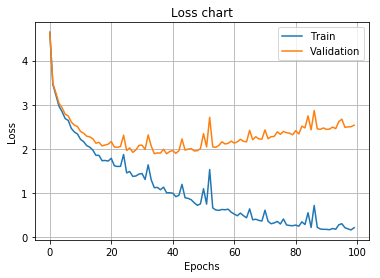

In [6]:
epochs = list(range(max_epoch))
train_loss = exp_results["train_loss"]
valid_loss = exp_results["valid_loss"]
lines = plt.plot(epochs, train_loss, epochs, valid_loss)

plt.legend(('Train', 'Validation'), loc='upper right')
plt.title('Loss chart')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

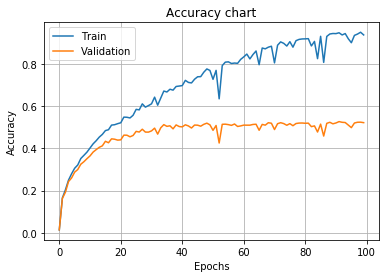

In [7]:
epochs = list(range(max_epoch))
train_metric = exp_results["train_met"]
valid_metric = exp_results["valid_met"]
lines = plt.plot(epochs, train_metric, epochs, valid_metric)

plt.legend(('Train', 'Validation'), loc='upper left')
plt.title('Accuracy chart')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()